In [1]:
import wikipedia
import bs4 as bs 
import urllib.request
from bs4 import BeautifulSoup
import re
from nltk.tokenize import sent_tokenize
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

/home/jeanedouard-rgz/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def get_category(language, subject):
    wikipedia.set_lang(language)
    source = urllib.request.urlopen(wikipedia.page(subject).url).read()
    soup = bs.BeautifulSoup(source,'lxml')
    soup_txt = str(soup.body)
    category = []
    for each_span in soup.find_all('span', {'class':'mw-headline'}):
        soup = BeautifulSoup(str(each_span).replace(' ','_'), "html.parser").getText()
        category.append(soup)
    return category

def get_data(language, subject):
    wikipedia.set_lang(language)
    source = urllib.request.urlopen(wikipedia.page(subject).url).read()
    soup = bs.BeautifulSoup(source,'lxml')
    soup_txt = str(soup.body)
    div = []
    for each_span in soup.find_all('span', {'class':'mw-headline'}):
        str(each_span).replace(' ','_')
        div.append(str(each_span))
    filter_tag = []
    i = 0
    while i < len(div)-1:
        start = div[i]
        end = div[i+1]
        text = soup_txt[soup_txt.find(start)+len(start):soup_txt.rfind(end)]
        soup = str(BeautifulSoup(text, "html.parser"))
        soup = re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", soup)
        soup = BeautifulSoup(soup, "html.parser")
        soup = re.compile(r'<img.*?/>').sub('', str(soup.find_all('p')))
        soup = BeautifulSoup(soup, "html.parser")
        soup = (re.sub("[^a-zA-Z,.;:!0-9]"," ",soup.getText()).replace('[','').replace(']','').lstrip().rstrip().lower())    
        clean_text = re.sub(' +', ' ',soup).replace(',',' ')
        filter_tag.append(clean_text)
        i += 1
    return filter_tag

def get_len_list(filter_tag):
    filtered_text = []
    len_list = []
    i = 0 
    while i < len(filter_tag):
        text = sent_tokenize(filter_tag[i])
        filtered_text.append(text)
        len_list.append(len(filtered_text[i]))
        i += 1
    return filtered_text,len_list

def generate_dataset(len_list, category):
    i = 0
    label_list = []
    while i < len(len_list):
        j = 0
        if len_list[i] != 0:
            while j != len_list[i]:
                label_list.append(category[i].lower())
                j += 1
        i += 1
    flat_list = [item for sublist in  get_len_list(get_data(language, subject))[0] for item in sublist]
    data = {'text': flat_list,'label': label_list}
    df = pd.DataFrame.from_dict(data)

    print(df.head())
    print('Repartition of labels:', df['label'].iloc[0])
    print('Data Shape:', df.shape)
    return df

def get_stop_words(language):
    if language == 'en':
        spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
    if language == 'fr':
        spacy_stopwords = spacy.lang.fr.stop_words.STOP_WORDS
    if language == 'de':
        spacy_stopwords = spacy.lang.de.stop_words.STOP_WORDS
    if language == 'es':
        spacy_stopwords = spacy.lang.es.stop_words.STOP_WORDS
    if language == 'pt':
        spacy_stopwords = spacy.lang.pt.stop_words.STOP_WORDS
    if language == 'it':
        spacy_stopwords = spacy.lang.it.stop_words.STOP_WORDS
    if language == 'nl':
        spacy_stopwords = spacy.lang.nl.stop_words.STOP_WORDS
    return spacy_stopwords

def clean_dataset(language, df):
    srce_labels = df.label.values.tolist()
    srce_text = df.text.values.tolist()
    spacy_stopwords = get_stop_words(language)
    clean_text = []
    text = []
    
    i = 0
    while i < len(srce_text):
        extract = []
        doc = nlp(srce_text[i])
        for token in doc:
            extract.append(token.lemma_)
        clean_text.append(",".join(extract).replace(","," ").replace("   "," "))
        i += 1
    print('Number of stop words: %d' % len(spacy_stopwords))
    i = 0
    while i < len(clean_text):
        doc = nlp(clean_text[i])
        tokens = [token.text for token in doc if not token.is_stop]
        text.append(",".join(tokens).replace(","," ").replace("  "," ").replace("    "," ").replace("-PRON-"," ").rstrip().lstrip())
        i += 1
    data = {'text': text,'label': srce_labels}
    df = pd.DataFrame.from_dict(data)
    return df

def create_model(df):
    print("Creating the bag of words...\n")
    vectorizer = CountVectorizer(analyzer = "word",   \
                                 tokenizer = None,    \
                                 preprocessor = None, \
                                 stop_words = None,   \
                                 max_features = 5000) 
    train_data_features = vectorizer.fit_transform(df.text.values.tolist())
    train_data_features = train_data_features.toarray()
    print(train_data_features)
    print(train_data_features.shape)
    vocab = vectorizer.get_feature_names()
    print(vocab)
    dist = np.sum(train_data_features, axis=0)
    for tag, count in zip(vocab, dist):
        print(count, tag)
    print("Training the random forest...")
    forest = RandomForestClassifier(n_estimators = 100) 
    forest = forest.fit(train_data_features, df["label"])
    filename = language+"_"+subject.replace(" ","_")+'.sav'
    pickle.dump(forest, open(filename, 'wb'))
    print('saving model as: '+filename)

     label                                               text
0  history  hussars originated in mercenary units of exile...
1  history  serbian lancers  also called racowie  were use...
2  history  the oldest mention of hussars in polish docume...
3  history  in the 15th century  light hussars based on th...
4  history  the polish hussars were originally based on th...
Repartition of labels: history
Data Shape: (83, 2)
Number of stop words: 305


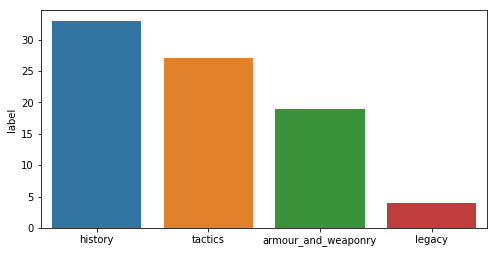

Creating the bag of words...

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]
(83, 535)
['100', '15', '1500', '1503', '1570s', '1574', '1576', '1577', '1590s', '15th', '1630s', '1653', '1670', '1670s', '1680', '1683', '16th', '1705', '1770s', '1776', '17th', '18th', '1st', '200', '2004', '2016', '30', '60', 'abandon', 'able', 'accept', 'accord', 'additional', 'adjustable', 'adopt', 'advanced', 'age', 'albeit', 'album', 'allow', 'appear', 'approach', 'arc', 'arm', 'armed', 'armour', 'armoured', 'army', 'arquebus', 'arrive', 'arrow', 'attach', 'attire', 'axe', 'badge', 'balkan', 'ball', 'band', 'banner', 'base', 'bathory', 'battle', 'battleax', 'beautiful', 'begin', 'behold', 'beresteczko', 'black', 'blacken', 'body', 'bow', 'branch', 'break', 'breed', 'bristle', 'bulk', 'byczyna', 'capacity', 'carbine', 'carry', 'case', 'cavalry', 'century', 'chain', 'character', 'characteristic', 'charge', 'cheekpiece', 'chocim', '

1 status
1 steel
1 stephen
1 steppe
1 stick
1 strangely
2 style
1 supply
1 swan
1 swedish
1 sword
3 szabla
2 szyszak
3 tactic
1 taffeta
1 tasset
6 tatar
2 tend
1 terminating
1 theory
4 thigh
1 time
1 title
9 towarzysz
1 tradition
1 transform
1 transition
1 tribe
1 true
1 trzciana
1 turk
1 turkic
1 turkish
3 type
2 uhlan
2 underneath
1 uniform
8 unit
6 use
6 usually
1 uszyn
2 vambrace
1 variant
2 victory
3 vienna
1 vincent
1 visor
1 walk
3 war
1 warhamm
2 warrior
1 warsaw
1 wealthy
4 weapon
6 wear
1 weight
4 western
2 wheellock
1 win
11 wing
1 winged
1 wood
5 wooden
1 write
Training the random forest...
saving model as: en_polish_hussars.sav


In [3]:
language = 'en'
subject = 'polish hussars'

nlp = spacy.load(language)
df = generate_dataset(get_len_list(get_data(language, subject))[1], get_category(language, subject))
df = clean_dataset(language, df)
df2 = df

fig = plt.figure(figsize=(8,4))
sns.barplot(x = df['label'].unique(), y=df['label'].value_counts())
plt.show()

forest = create_model(df)

     label                                               text
0  history  hussars originated in mercenary units of exile...
1  history  serbian lancers  also called racowie  were use...
2  history  the oldest mention of hussars in polish docume...
3  history  in the 15th century  light hussars based on th...
4  history  the polish hussars were originally based on th...
Repartition of labels: history
Data Shape: (83, 2)
Number of stop words: 305
     label                                               text
0  history  hussar originate mercenary unit exile serbian ...
1  history  serbian lancer racowie use counter ottoman sip...
2  history  old mention hussar polish document date 1500  ...
3  history  15th century light hussar base hungarian king ...
4  history   polish hussar originally base hungarian hussar .


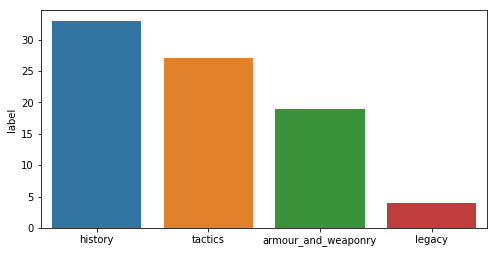

In [4]:
language = 'en'
subject = 'polish hussars'

nlp = spacy.load(language)
df = generate_dataset(get_len_list(get_data(language, subject))[1], get_category(language, subject))
df = clean_dataset(language, df)
print(df.head())


fig = plt.figure(figsize=(8,4))
sns.barplot(x = df['label'].unique(), y=df['label'].value_counts())
plt.show()

In [5]:
print("Creating the bag of words...\n")
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(df.text.values.tolist())

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()
print(train_data_features.shape)
vocab = vectorizer.get_feature_names()
print(vocab)
import numpy as np

# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(vocab, dist):
    print(count, tag)

Creating the bag of words...

(83, 535)
['100', '15', '1500', '1503', '1570s', '1574', '1576', '1577', '1590s', '15th', '1630s', '1653', '1670', '1670s', '1680', '1683', '16th', '1705', '1770s', '1776', '17th', '18th', '1st', '200', '2004', '2016', '30', '60', 'abandon', 'able', 'accept', 'accord', 'additional', 'adjustable', 'adopt', 'advanced', 'age', 'albeit', 'album', 'allow', 'appear', 'approach', 'arc', 'arm', 'armed', 'armour', 'armoured', 'army', 'arquebus', 'arrive', 'arrow', 'attach', 'attire', 'axe', 'badge', 'balkan', 'ball', 'band', 'banner', 'base', 'bathory', 'battle', 'battleax', 'beautiful', 'begin', 'behold', 'beresteczko', 'black', 'blacken', 'body', 'bow', 'branch', 'break', 'breed', 'bristle', 'bulk', 'byczyna', 'capacity', 'carbine', 'carry', 'case', 'cavalry', 'century', 'chain', 'character', 'characteristic', 'charge', 'cheekpiece', 'chocim', 'chor', 'citation', 'citizen', 'clash', 'clatter', 'claws', 'close', 'closed', 'coat', 'coin', 'collateral', 'colour', 'c

1 obertyn
1 obligation
1 obrona
1 obsolete
1 ochmat
1 odd
1 offensive
2 officer
3 old
1 onka
1 onwards
1 organized
1 oriental
1 originally
3 originate
1 orsza
2 ostrich
3 ottoman
1 otych
1 outnumber
1 outside
1 overwhelming
1 owner
3 pace
1 pad
3 paint
1 palasz
1 palm
1 pancerny
1 parade
1 parliamentary
1 participate
1 partly
1 pass
1 penalty
1 pennon
2 period
1 persian
3 pistol
1 plat
2 plate
1 play
1 po
2 poczet
2 point
5 poland
1 poleyn
23 polish
2 popular
1 porucznik
1 possibility
1 possibly
1 potoczna
1 power
1 predecessor
1 primary
1 probably
1 proporzec
3 protection
1 prove
4 provide
1 prowess
3 quick
1 quickly
1 quiver
1 racowie
2 raise
1 range
2 rank
1 reach
1 reality
1 reconnaissance
1 recover
1 recruit
1 recruitment
1 reflex
3 reform
1 regular
2 reign
2 relatively
1 remain
1 remark
1 renaissance
1 reorganize
1 repair
1 repeat
2 replace
1 represent
1 republic
1 require
1 result
5 retainer
2 retinue
1 richly
1 rid
1 right
1 rivet
1 rk
3 role
1 rotmistrz
1 royal
1 run
1 russian

In [6]:
print("Training the random forest...")
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 100) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
forest = forest.fit( train_data_features, df["label"] )

Training the random forest...


In [7]:
# Create an empty list and append the clean reviews one by one
clean_test_reviews = ['hussar originate mercenary unit exile serbian warrior'] 


# Get a bag of words for the test set, and convert to a numpy array
test_data_features = vectorizer.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

# Use the random forest to make sentiment label predictions
result = forest.predict(test_data_features)
print(result)

['history']
